I want to figure out how to compute laplacian eigenvectors on an arbitrary 2D region.

To do this I need to have several ingredients:
1. some kind of mathematical expression for the region of interest
2. a finite-difference approximation of the Laplacian
3. a grid

What I want to do is write down a function $f(x,y)$ such that the region of interest is $\{(x,y) | f(x,y)>0\}$

In [106]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
from scipy.sparse import spdiags, kronsum
import matplotlib.pyplot as plt


def rectangular_grid(x0, y0, x1, y1, Nx=100, Ny=100):
    x = np.linspace(x0, x1, Nx)
    y = np.linspace(y0, y1, Ny)
    return np.meshgrid(x, y)

def get_square_projector(grid, region):
    # given a discrete grid and a function that determines the shape of a region of interest, returns a projection operator onto the subspace of functions with support in the region
    # this assumes that the functions are represented as vectors flattened in "row-major" order, i.e. f = f(X, Y).reshape(Nx*Ny) or f(X, Y).flatten()
    return spdiags([(region(*grid)>0).flatten().astype('int')], diags = [0])

def get_rectangular_projector(grid, region):
    Nx, Ny = grid[0].shape
    col, = np.where((region(*grid)>0).flatten())
    row = np.arange(len(col))
    data = np.ones_like(row)
    P = sp.sparse.coo_matrix((data, (row, col)), shape = (len(col), Nx*Ny))
    return sp.sparse.csr_matrix(P)

def get_laplacian(grid):
    X, Y = grid
    Nx, Ny = X.shape
    dx = (X.max() - X.min())/Nx
    dy = (Y.max() - Y.min())/Ny
    diagx = np.ones([Nx])
    diagy = np.ones([Ny])
    diagsy = np.array([diagy, -2*diagy, diagy])
    diagsx = np.array([diagx, -2*diagx, diagx])
    Dx = spdiags(diagsx, [-1,0,1], Nx, Ny)/dx**2
    Dy = spdiags(diagsy, [-1,0,1], Nx, Ny)/dy**2
    return kronsum(Dx, Dy)

In [107]:

def region_function(x,y):
    return 1/2-(y-(1-x**2))**2


grid = rectangular_grid(-2, -2, 2, 2, Nx=200, Ny=200)

P = get_rectangular_projector(grid, region_function)
L = get_laplacian(grid)
M = P@L@P.T
eigenvalues, eigenvectors = eigsh(-M, k=12, which = 'SM')

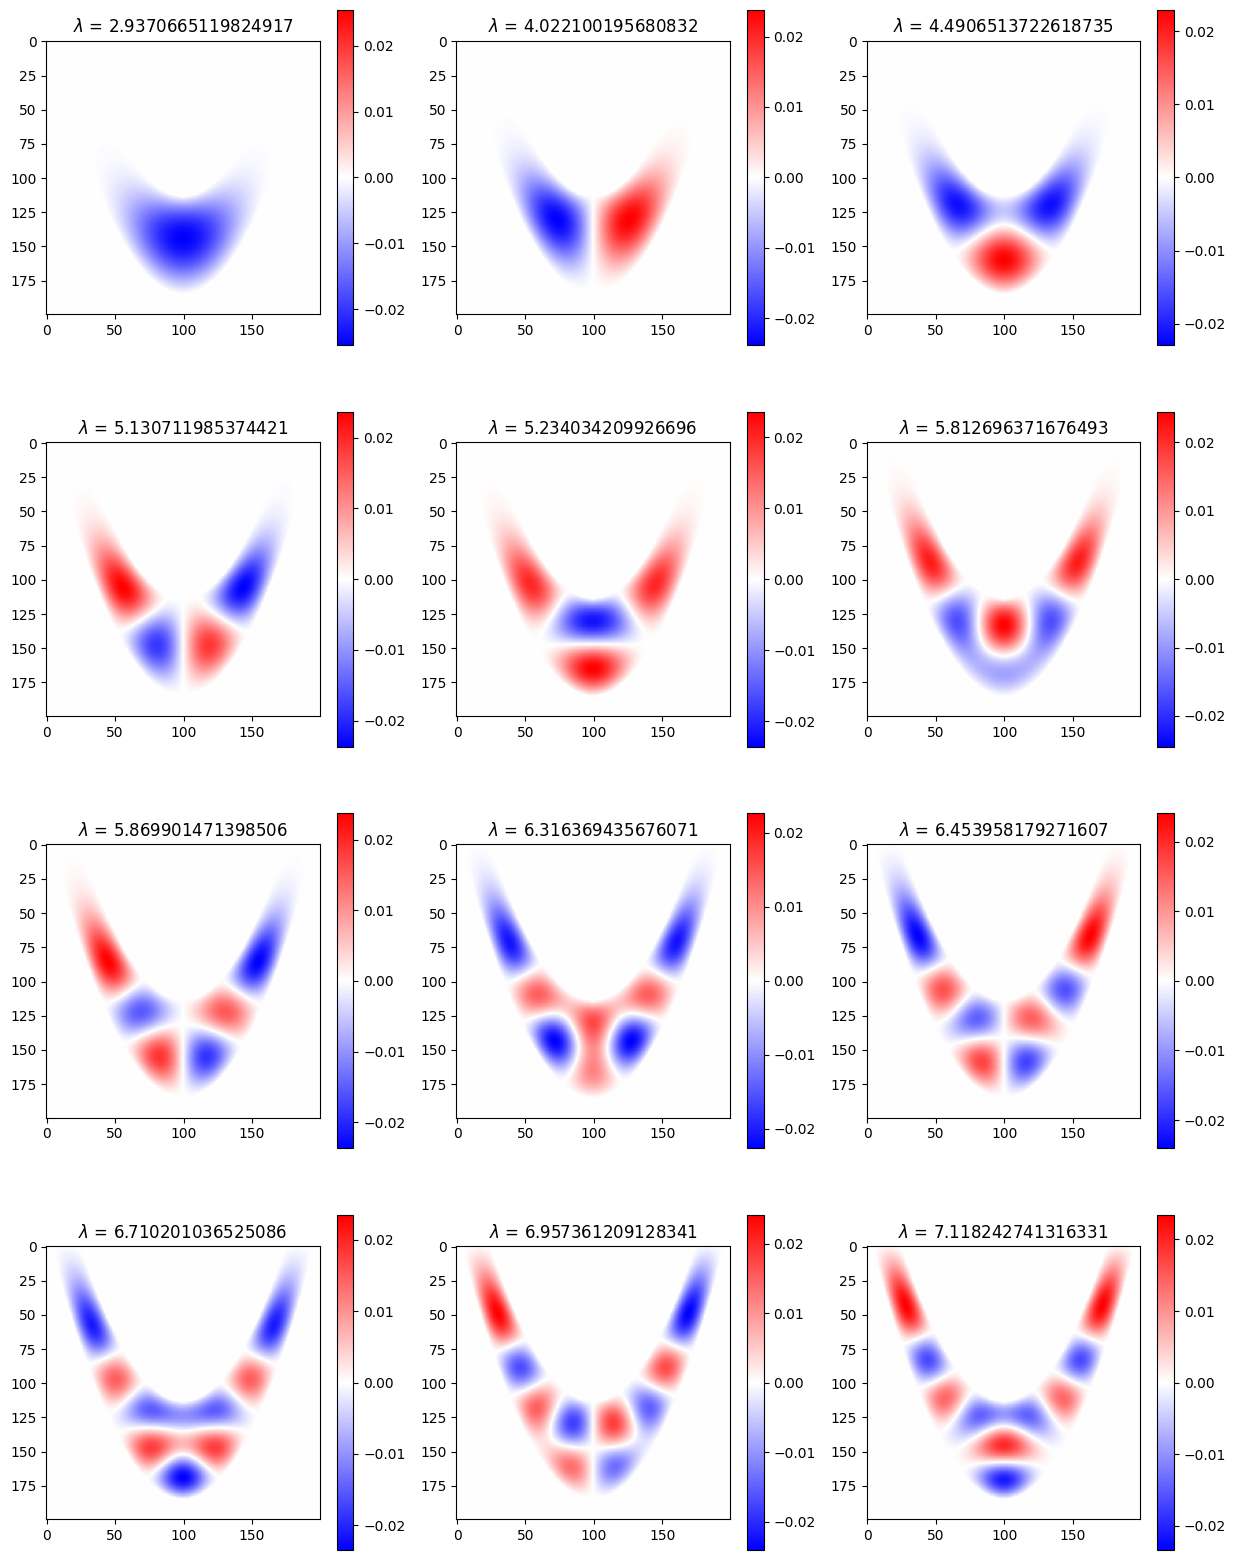

In [109]:
Nx, Ny = grid[0].shape
plt.figure(figsize = (15, 20))
for i in range(12):
    plt.subplot(4, 3, i+1)
    img = (P.T@eigenvectors[:,i]).reshape(Nx, Ny).real
    v = max(img.max(), -img.min())
    plt.imshow(img, cmap = 'bwr', vmin = -v, vmax = v)
    plt.title(f'$\lambda$ = {np.sqrt(eigenvalues[i])}')
    plt.colorbar()
plt.savefig('foo.svg')

In [20]:
u, s, v = sp.sparse.linalg.svds(-M, k=100, which = 'SM')

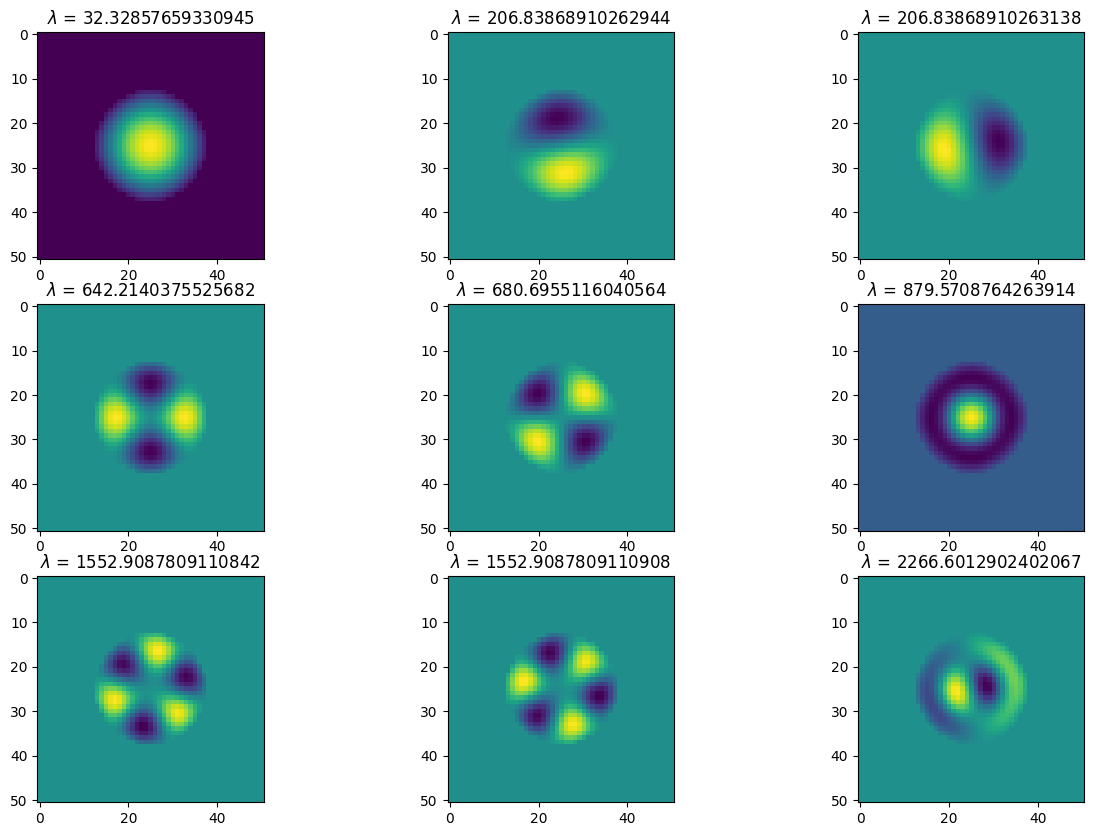

In [30]:
k0=(s<1e-10).sum()
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(v[i+k0,:].reshape(Nx, Ny))
    plt.title(f'$\lambda$ = {s[k0+i]**2}')

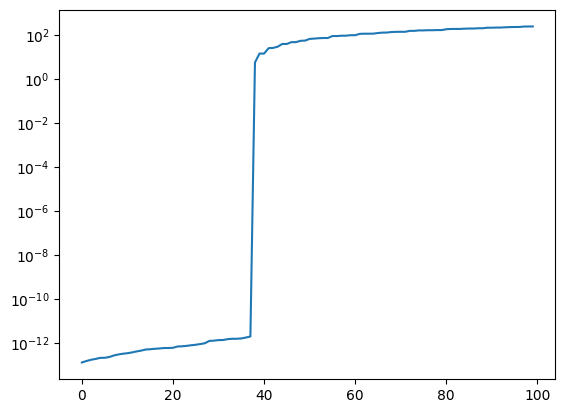

In [23]:
plt.semilogy(s)

In [121]:
# try 1D case to sanity check
import scipy
x = np.linspace(-1, 1, 10)
d0 = np.ones(len(x))
Dx = spdiags([d0, -2*d0, d0], [-1,0,1])
D = kronsum(Dx, Dx)


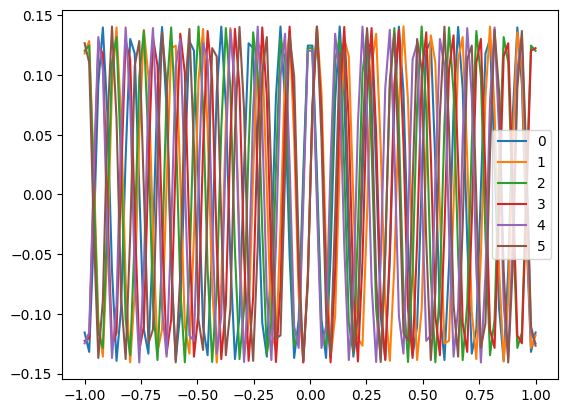

In [113]:
plt.plot(x, evecs)
plt.legend(range(6))

In [112]:
evecs.shape

(100, 6)

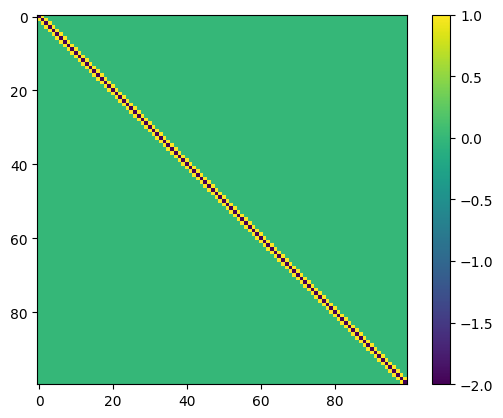

In [117]:
plt.imshow(Dx.toarray())
plt.colorbar()

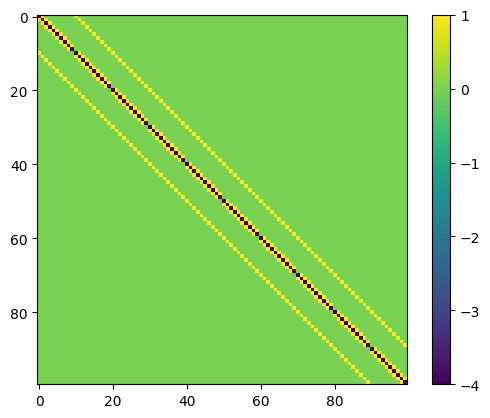

In [122]:
plt.imshow(D.toarray())
plt.colorbar()

In [134]:
v, w = eigsh(-D, k=99)

In [135]:
v

array([0.39850699, 0.39850699, 0.63498587, 0.77129258, 0.77129258,
       1.00777147, 1.00777147, 1.25018403, 1.25018403, 1.38055706,
       1.48666291, 1.48666291, 1.79638438, 1.79638438, 1.85944851,
       1.85944851, 2.03286326, 2.03286326, 2.33833995, 2.36564373,
       2.36564373, 2.40564886, 2.40564886, 2.60212261, 2.60212261,
       2.8845403 , 2.8845403 , 2.91184408, 2.91184408, 2.97490821,
       2.97490821, 3.14832296, 3.14832296, 3.39073552, 3.39073552,
       3.43074065, 3.45379965, 3.45379965, 3.52110856, 3.52110856,
       3.6272144 , 3.6272144 , 3.76352112, 3.76352112, 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.23647888,
       4.23647888, 4.3727856 , 4.3727856 , 4.47889144, 4.47889144,
       4.54620035, 4.54620035, 4.56925935, 4.60926448, 4.60926448,
       4.85167704, 4.85167704, 5.02509179, 5.02509179, 5.08815592,
       5.08815592, 5.1154597 , 5.1154597 , 5.39787739, 5.39787

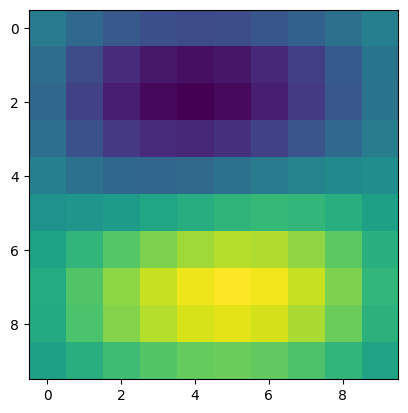

In [137]:
plt.imshow(w[:,1].reshape(10,10))